In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.ticker as ticker
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import K2Score, BicScore, BDeuScore, HillClimbSearch, BayesianEstimator
from imblearn.over_sampling import SMOTE
from collections import Counter

## 1. Data Cleaning

### 1-1. Raw Data

In [2]:
df_trip = pd.read_csv('../data/trippub.csv', error_bad_lines=False)
df_hh = pd.read_csv('../data/hhpub.csv', error_bad_lines=False)
df_per = pd.read_csv('../data/perpub.csv', error_bad_lines=False)
df_veh = pd.read_csv('../data/vehpub.csv', error_bad_lines=False)

### 1-2. Extract features that are the causes of the travel mode choice

Features that are the results of the travel mode choice are excluded.  
e.g. trip duration, driver flag

https://nhts.ornl.gov/tables09/CodebookBrowser.aspx

In [3]:
col_trip_all = [
    'DBHTNRNT', \
    'DBHUR', \
    'DBPPOPDN', \
    'DBRESDN', \
    'DTEEMPDN', \
    'DTHTNRNT', \
    'DTPPOPDN', \
    'DTRESDN', \
    'EDUC', \
    'GASPRICE', \
    'HHFAMINC', \
    'HHSIZE', \
    'HHSTATE', \
    'HHVEHCNT', \
    'HH_HISP', \
    'HH_ONTD', \
    'HH_RACE', \
    'HOMEOWN', \
    'HOUSEID', \
    'LIF_CYC', \
    'LOOP_TRIP', \
    'NONHHCNT', \
    'NUMADLT', \
    'NUMONTRP', \
    'OBHTNRNT', \
    'OBHUR', \
    'OBPPOPDN', \
    'OBRESDN', \
    'OTEEMPDN', \
    'OTHTNRNT', \
    'OTPPOPDN', \
    'OTRESDN', \
    'PERSONID', \
    'PRMACT', \
    'R_AGE', \
    'R_AGE_IMP', \
    'R_SEX', \
    'R_SEX_IMP', \
    'STRTTIME', \
    'TDAYDATE', \
    'TDWKND', \
    'TRAVDAY', \
    'TRIPPURP', \
    'TRPACCMP', \
    'TRPHHACC', \
    'TRPTRANS', \
    'URBAN', \
    'URBANSIZE', \
    'URBRUR', \
    'WHYTRP1S', \
    'WORKER', \
    'WRKCOUNT', \
    'WTTRDFIN'
]

In [4]:
col_veh_all = [
    'ANNMILES', \
    'BESTMILE', \
    'BEST_EDT', \
    'BEST_FLG', \
    'BEST_OUT', \
    'FEGEMPG', \
    'FEGEMPGA', \
    'FEGEMPGF', \
    'FUELTYPE', \
    'GSCOST', \
    'GSTOTCST', \
    'GSYRGAL', \
    'HBHTNRNT', \
    'HBHUR', \
    'HBPPOPDN', \
    'HBRESDN', \
    'HFUEL', \
    'HHFAMINC', \
    'HHSIZE', \
    'HHVEHCNT', \
    'HH_HISP', \
    'HH_RACE', \
    'HOMEOWN', \
    'HOUSEID', \
    'HTEEMPDN', \
    'HTHTNRNT', \
    'HTPPOPDN', \
    'HTRESDN', \
    'HYBRID', \
    'LIF_CYC', \
    'MAKE', \
    'MODEL', \
    'NUMADLT', \
    'OD_READ', \
    'PERSONID', \
    'TDAYDATE', \
    'TRAVDAY', \
    'URBAN', \
    'URBANSIZE', \
    'URBRUR', \
    'VEHAGE', \
    'VEHOWNED', \
    'VEHOWNMO', \
    'VEHYEAR', \
    'WHOMAIN', \
    'WRKCOUNT', \
    'WTHHFIN'
]

In [5]:
col_per_all = [
    'ALT_16', \
    'ALT_23', \
    'ALT_45', \
    'BIKE4EX', \
    'BIKESHARE', \
    'BIKE_DFR', \
    'BIKE_GKP', \
    'BORNINUS', \
    'CARRODE', \
    'CARSHARE', \
    'CONDNIGH', \
    'CONDPUB', \
    'CONDRIDE', \
    'CONDRIVE', \
    'CONDSPEC', \
    'CONDTAX', \
    'CONDTRAV', \
    'DELIVER', \
    'DISTTOSC17', \
    'DISTTOWK17', \
    'EDUC', \
    'FLEXTIME', \
    'FRSTHM17', \
    'GCDWORK', \
    'GT1JBLWK', \
    'HBHTNRNT', \
    'HBHUR', \
    'HBPPOPDN', \
    'HBRESDN', \
    'HEALTH', \
    'HHFAMINC', \
    'HHSIZE', \
    'HHVEHCNT', \
    'HH_HISP', \
    'HH_RACE', \
    'HOMEOWN', \
    'HOUSEID', \
    'HTEEMPDN', \
    'HTHTNRNT', \
    'HTPPOPDN', \
    'HTRESDN', \
    'LIF_CYC', \
    'LPACT', \
    'LSTTRDAY17', \
    'MCUSED', \
    'MEDCOND', \
    'MEDCOND6', \
    'NBIKETRP', \
    'NOCONG', \
    'NUMADLT', \
    'NWALKTRP', \
    'OCCAT', \
    'OUTCNTRY', \
    'OUTOFTWN', \
    'PAYPROF', \
    'PERSONID', \
    'PHYACT', \
    'PRMACT', \
    'PTUSED', \
    'PUBTIME', \
    'RIDESHARE', \
    'R_AGE', \
    'R_AGE_IMP', \
    'R_HISP', \
    'R_RACE', \
    'R_RELAT', \
    'R_SEX', \
    'R_SEX_IMP', \
    'SAMEPLC', \
    'SCHTYP', \
    'TDAYDATE', \
    'TIMETOWK', \
    'TRAVDAY', \
    'URBAN', \
    'URBANSIZE', \
    'URBRUR', \
    'VPACT', \
    'WALK4EX', \
    'WALK_DEF', \
    'WALK_GKQ', \
    'WKFMHMXX', \
    'WKFTPT', \
    'WKRMHM', \
    'WORKER', \
    'WRKCOUNT', \
    'WRK_HOME', \
    'WTPERFIN', \
    'W_CANE', \
    'W_CHAIR', \
    'W_CRUTCH', \
    'W_DOG', \
    'W_MTRCHR', \
    'W_NONE', \
    'W_SCOOTR', \
    'W_WHCANE', \
    'W_WLKR', \
    'YEARMILE', \
    'YRTOUS'
]

In [6]:
col_hh_all = [
    'BIKE', \
    'BIKE2SAVE', \
    'BUS', \
    'CAR', \
    'HBHTNRNT', \
    'HBHUR', \
    'HBPPOPDN', \
    'HBRESDN', \
    'HHFAMINC', \
    'HHRELATD', \
    'HHSIZE', \
    'HHVEHCNT', \
    'HH_HISP', \
    'HH_RACE', \
    'HOMEOWN', \
    'HOUSEID', \
    'HTEEMPDN', \
    'HTHTNRNT', \
    'HTPPOPDN', \
    'HTRESDN', \
    'LIF_CYC', \
    'NUMADLT', \
    'PARA', \
    'PC', \
    'PLACE', \
    'PRICE', \
    'PTRANS', \
    'SPHONE', \
    'TAB', \
    'TAXI', \
    'TDAYDATE', \
    'TRAIN', \
    'TRAVDAY', \
    'URBAN', \
    'URBANSIZE', \
    'URBRUR', \
    'WALK', \
    'WALK2SAVE', \
    'WEBUSE17', \
    'WRKCOUNT', \
    'WTHHFIN', \
    'YOUNGCHILD'
]

### 1-3. Remove duplicate features

In [7]:
col_trip = col_trip_all # trip
col_hh = [i for i in col_hh_all if i not in col_trip] # household - trip
col_per = [i for i in col_per_all if i not in col_trip + col_hh] # person - trip - household
col_veh = [i for i in col_veh_all if i not in col_trip + col_hh + col_per] # vehicle - trip - household - person

In [8]:
# append id for join
col_hh.append('HOUSEID')
col_per.extend(['HOUSEID', 'PERSONID'])

In [9]:
print(len(col_trip), len(col_hh), len(col_per), len(col_veh))

53 28 69 22


In [10]:
df_trip_stg = df_trip[col_trip]
df_hh_stg = df_hh[col_hh]
df_per_stg = df_per[col_per]
df_veh_stg = df_veh[col_veh]

In [11]:
df_trip_hh = pd.merge(df_trip_stg, df_hh_stg, how='left', left_on='HOUSEID', right_on='HOUSEID')

In [12]:
df_merge_stg = pd.merge(df_trip_hh, df_per_stg, how='left', left_on=['HOUSEID', 'PERSONID'], right_on=['HOUSEID', 'PERSONID'])

In [13]:
df_merge_stg.head()

DBHTNRNT DBHUR  DBPPOPDN  DBRESDN  DTEEMPDN  DTHTNRNT  DTPPOPDN  DTRESDN  \
0        30     T       300      300       350        50       750      300   
1        20     T       750      300       750        50      1500      750   
2        20     T       750      300       750        50      1500      750   
3        40     S      1500      750       750        40      1500      750   
4        60     T       750      300       350        50       750      300   

   EDUC  GASPRICE  ...  W_CHAIR  W_CRUTCH W_DOG  W_MTRCHR  W_NONE  W_SCOOTR  \
0     3     228.4  ...       -1        -1    -1        -1      -1        -1   
1     3     228.4  ...       -1        -1    -1        -1      -1        -1   
2     3     228.4  ...       -1        -1    -1        -1      -1        -1   
3     3     228.4  ...       -1        -1    -1        -1      -1        -1   
4     2     228.4  ...       -1        -1    -1        -1      -1        -1   

   W_WHCANE  W_WLKR  YEARMILE  YRTOUS  
0        -1      -1      1000      -1  
1        -1      -1      1000      -1  
2        -1      -1     10000      -1  
3        -1      -1     10000      -1  
4        -1      -1      1000      -1  

[5 rows x 147 columns]

In [14]:
print(len(df_trip), len(df_trip_hh))

923572 923572


In [15]:
print(len(df_merge_stg))

923572


### 1-4. Group Target

In [16]:
def tripmode(x):
    if x in (1, 2, 11, 15, 16): # walk, bike, public transit
        return 1
    else:
        return 0
    
'''
def tripmode(x):
    if x in (1, 2):
        return 0 # soft mode (walk or bicycle)
    elif x in (3, 4, 5, 6, 7, 8, 9, 18):
        return 1 # car
    elif x in (11, 15, 16):
        return 2 # public transit
    else:
        return 3 # other
'''

'\ndef tripmode(x):\n    if x in (1, 2):\n        return 0 # soft mode (walk or bicycle)\n    elif x in (3, 4, 5, 6, 7, 8, 9, 18):\n        return 1 # car\n    elif x in (11, 15, 16):\n        return 2 # public transit\n    else:\n        return 3 # other\n'

In [17]:
df_merge_stg['TARGET'] = df_merge_stg['TRPTRANS'].apply(tripmode)
df_merge = df_merge_stg.drop(['TRPTRANS'], axis=1)

In [18]:
df_merge['TARGET'].value_counts()

0    823160
1    100412
Name: TARGET, dtype: int64

### 1-5. Convert to float

In [19]:
col_cat = []
for col in df_merge.columns:
    try:
        _ = df_merge[col].astype(float)
    except ValueError:
        print('Couldn\'t covert %s to float' % col)
        col_cat.append(col)
        pass

Couldn't covert DBHUR to float
Couldn't covert HHSTATE to float
Couldn't covert OBHUR to float
Couldn't covert TRIPPURP to float
Couldn't covert HBHUR to float


### 1-6. Extract NY

In [20]:
df_merge = df_merge[df_merge['HHSTATE'] == 'NY']

## 2. Feature Selection for Bayesian Networks

### 2-1. Select features

In [21]:
# correlation with the target
cor = df_merge.drop(col_cat + ['TARGET'], axis=1).apply(lambda x: x.corr(df_merge['TARGET']))

In [22]:
df_cor = pd.DataFrame(cor).rename(columns={0: 'correlation'}).dropna()

<AxesSubplot:>

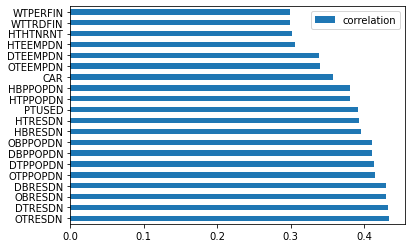

In [23]:
# top positive correlation
df_cor.sort_values(by='correlation', ascending=False).iloc[:20].plot.barh()

<AxesSubplot:>

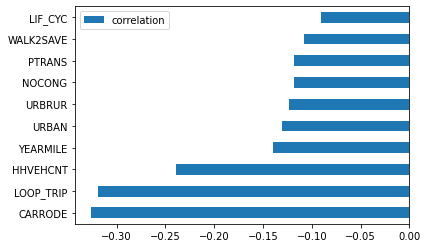

In [24]:
# top negative correlation
df_cor.sort_values(by='correlation').iloc[:10].plot.barh()

In [29]:
# cut off line: equal to or more than 0.4 + equal to or less than -0.4
cut = 0.4

In [30]:
df_cor[df_cor['correlation'].apply(lambda x: np.abs(x)) >= cut].sort_index()

correlation
DBPPOPDN     0.410555
DBRESDN      0.429827
DTPPOPDN     0.414214
DTRESDN      0.433299
OBPPOPDN     0.410550
OBRESDN      0.430451
OTPPOPDN     0.415098
OTRESDN      0.434390

In [38]:
# clus_col = df_cor[df_cor['correlation'].apply(lambda x: np.abs(x)) >= 0.2].index

In [39]:
# clus_col = sorted(list(clus_col))

Due to the computation, we select 8 features.

In [37]:
clus_col = ['CARRODE', 'LOOP_TRIP', 'HHVEHCNT', 'PTUSED', 'OTRESDN', 'OBRESDN', 'OTPPOPDN', 'OBPPOPDN']

In [38]:
df_ny = df_merge[clus_col + ['TARGET']]

In [39]:
df_ny.head()

CARRODE  LOOP_TRIP  HHVEHCNT  PTUSED  OTRESDN  OBRESDN  OTPPOPDN  \
8         1          2         2       0    17000     7000     17000   
9         1          2         2       0      300      300       750   
10        1          2         2       0    17000     7000     17000   
11        1          2         2       0     7000     1500     17000   
12        1          2         2       0    17000     7000     17000   

    OBPPOPDN  TARGET  
8      17000       0  
9        750       0  
10     17000       0  
11      3000       0  
12     17000       0

## 3. Bayesian Networks

### 3-1. Training and Test data

In [111]:
df_ny_train, df_ny_test = train_test_split(df_ny, test_size=0.3)

### 3-2. Structure learning

In [112]:
hc = HillClimbSearch(df_ny_train, scoring_method=BicScore(df_ny_train))

In [113]:
best_model = BayesianModel(hc.estimate().edges())

  0%|          | 19/1000000 [00:03<51:44:05,  5.37it/s]


In [114]:
print(best_model.edges())

[('CARRODE', 'PTUSED'), ('CARRODE', 'HHVEHCNT'), ('CARRODE', 'TARGET'), ('PTUSED', 'OTRESDN'), ('PTUSED', 'TARGET'), ('HHVEHCNT', 'OTRESDN'), ('TARGET', 'HHVEHCNT'), ('TARGET', 'OTRESDN'), ('TARGET', 'OTPPOPDN'), ('LOOP_TRIP', 'TARGET'), ('LOOP_TRIP', 'HHVEHCNT'), ('LOOP_TRIP', 'OTRESDN'), ('OTRESDN', 'OTPPOPDN'), ('OTRESDN', 'OBRESDN'), ('OTRESDN', 'OBPPOPDN'), ('OTPPOPDN', 'OBPPOPDN'), ('OTPPOPDN', 'OBRESDN'), ('OBRESDN', 'OBPPOPDN')]


In [115]:
flat = []
for i in list(best_model.edges()):
    flat.append(i[0])
    flat.append(i[1])

In [116]:
list(set(flat))

['CARRODE',
 'OBRESDN',
 'TARGET',
 'PTUSED',
 'OBPPOPDN',
 'LOOP_TRIP',
 'HHVEHCNT',
 'OTRESDN',
 'OTPPOPDN']

All features are used for bayesian networks.

### 3-3.Parameter learning

In [117]:
best_model.fit(df_ny_train, estimator=BayesianEstimator, prior_type='K2')

In [118]:
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of CARRODE:
+-------------+-------------+
| CARRODE(-9) | 0.0830937   |
+-------------+-------------+
| CARRODE(-8) | 3.56472e-05 |
+-------------+-------------+
| CARRODE(-7) | 8.31769e-05 |
+-------------+-------------+
| CARRODE(-1) | 0.516457    |
+-------------+-------------+
| CARRODE(1)  | 0.359336    |
+-------------+-------------+
| CARRODE(2)  | 0.0320112   |
+-------------+-------------+
| CARRODE(3)  | 0.00630956  |
+-------------+-------------+
| CARRODE(4)  | 0.00142589  |
+-------------+-------------+
| CARRODE(5)  | 0.000499061 |
+-------------+-------------+
| CARRODE(6)  | 8.31769e-05 |
+-------------+-------------+
| CARRODE(7)  | 0.000190119 |
+-------------+-------------+
| CARRODE(8)  | 8.31769e-05 |
+-------------+-------------+
| CARRODE(10) | 0.000202001 |
+-------------+-------------+
| CARRODE(20) | 0.000190119 |
+-------------+-------------+
CPD of PTUSED:
+------------+------------------------+---------------------+---------------------+----------------

### 3-4. Prediction

In [120]:
pred_bn_train = best_model.predict(df_ny_train.drop(['TARGET'], axis=1))


100%|██████████| 9765/9765 [12:29<00:00, 13.03it/s]


In [126]:
pred_bn_test = best_model.predict(df_ny_test.drop(['TARGET'], axis=1))


100%|██████████| 6381/6381 [06:57<00:00, 15.27it/s]


### 3-5. Performance on the training set

In [125]:
pd.DataFrame(confusion_matrix(df_ny_train['TARGET'], pred_bn_train), index=['Actual 0', 'Actual 1'], columns=['Prediction 0', 'Prediction 1'])

Prediction 0  Prediction 1
Actual 0         69634          1746
Actual 1          5502          7262

In [121]:
accuracy_score(df_ny_train['TARGET'], pred_bn_train)

0.9138619509412436

In [122]:
precision_score(df_ny_train['TARGET'], pred_bn_train)

0.8061722912966253

In [123]:
recall_score(df_ny_train['TARGET'], pred_bn_train)

0.5689439047320589

In [124]:
f1_score(df_ny_train['TARGET'], pred_bn_train)

0.667095351828036

### 3-6. Performance on the test set

In [128]:
pd.DataFrame(confusion_matrix(df_ny_test['TARGET'], pred_bn_test), index=['Actual 0', 'Actual 1'], columns=['Prediction 0', 'Prediction 1'])

Prediction 0  Prediction 1
Actual 0         29906           817
Actual 1          2417          2923

In [129]:
accuracy_score(df_ny_test['TARGET'], pred_bn_test)

0.9103236003660261

In [130]:
precision_score(df_ny_test['TARGET'], pred_bn_test)

0.7815508021390374

In [131]:
recall_score(df_ny_test['TARGET'], pred_bn_test)

0.547378277153558

In [132]:
f1_score(df_ny_test['TARGET'], pred_bn_test)

0.6438325991189426

#### Not used

In [40]:
hc = HillClimbSearch(df_ny, scoring_method=BicScore(df_ny))

In [50]:
best_model = BayesianModel(hc.estimate().edges())

  0%|          | 19/1000000 [00:05<74:41:17,  3.72it/s] 


In [51]:
print(best_model.edges())

[('CARRODE', 'PTUSED'), ('CARRODE', 'HHVEHCNT'), ('CARRODE', 'TARGET'), ('CARRODE', 'OTRESDN'), ('CARRODE', 'LOOP_TRIP'), ('PTUSED', 'OTRESDN'), ('PTUSED', 'TARGET'), ('TARGET', 'HHVEHCNT'), ('TARGET', 'OTPPOPDN'), ('OTRESDN', 'OTPPOPDN'), ('OTRESDN', 'OBRESDN'), ('OTRESDN', 'TARGET'), ('OTRESDN', 'OBPPOPDN'), ('LOOP_TRIP', 'TARGET'), ('OTPPOPDN', 'OBPPOPDN'), ('OTPPOPDN', 'OBRESDN'), ('OBRESDN', 'HHVEHCNT'), ('OBPPOPDN', 'OBRESDN')]


In [52]:
flat = []
for i in list(best_model.edges()):
    flat.append(i[0])
    flat.append(i[1])

In [53]:
list(set(flat))

['CARRODE',
 'OBRESDN',
 'TARGET',
 'PTUSED',
 'OBPPOPDN',
 'LOOP_TRIP',
 'HHVEHCNT',
 'OTRESDN',
 'OTPPOPDN']

All features are used for bayesian networks.

In [56]:
best_model.fit(df_ny, estimator=BayesianEstimator, prior_type='K2')

In [57]:
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of CARRODE:
+-------------+-------------+
| CARRODE(-9) | 0.0836875   |
+-------------+-------------+
| CARRODE(-8) | 2.4954e-05  |
+-------------+-------------+
| CARRODE(-7) | 6.65441e-05 |
+-------------+-------------+
| CARRODE(-1) | 0.517089    |
+-------------+-------------+
| CARRODE(1)  | 0.357533    |
+-------------+-------------+
| CARRODE(2)  | 0.0325983   |
+-------------+-------------+
| CARRODE(3)  | 0.00633001  |
+-------------+-------------+
| CARRODE(4)  | 0.00137247  |
+-------------+-------------+
| CARRODE(5)  | 0.000524035 |
+-------------+-------------+
| CARRODE(6)  | 7.48621e-05 |
+-------------+-------------+
| CARRODE(7)  | 0.000191314 |
+-------------+-------------+
| CARRODE(8)  | 0.000133088 |
+-------------+-------------+
| CARRODE(10) | 0.000199632 |
+-------------+-------------+
| CARRODE(20) | 0.000174678 |
+-------------+-------------+
CPD of PTUSED:
+------------+------------------------+---------------------+-------------+------------------------

In [59]:
pred = best_model.predict(df_ny.drop(['TARGET'], axis=1))

100%|██████████| 11404/11404 [13:20<00:00, 14.25it/s]


In [69]:
pd.DataFrame(confusion_matrix(df_ny['TARGET'], pred), index=['Actual 0', 'Actual 1'], columns=['Prediction 0', 'Prediction 1'])

Prediction 0  Prediction 1
Actual 0         99695          2408
Actual 1          8081         10023

In [63]:
accuracy_score(df_ny['TARGET'], pred)

0.912742186395135

In [64]:
precision_score(df_ny['TARGET'], pred)

0.806290724800901

In [65]:
recall_score(df_ny['TARGET'], pred)

0.5536345558992488

In [66]:
f1_score(df_ny['TARGET'], pred)

0.6564925495333225

## 4. Random Forest

### 4-1. One Hot Encoding

In [76]:
col_cat_rf = [i for i in col_cat if i != 'HHSTATE']
df_merge_stg = pd.get_dummies(df_merge.drop(['HHSTATE'], axis=1), columns=col_cat_rf)

### 4-2. Remove ID columns

In [84]:
df_rf = df_merge_stg.drop(['HOUSEID', 'PERSONID'], axis=1)

### 4-3. Training and Test Data

In [85]:
y = df_rf['TARGET']
X = df_rf.drop(['TARGET'], axis=1)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [87]:
print(X_train.shape, X_test.shape, y_train.shape,  y_test.shape)

(84144, 163) (36063, 163) (84144,) (36063,)


### 4-4. Modeling with GridSearchCV

In [148]:
param_grid = {'n_estimators':range(1,51,5),
              'max_depth':[5, 10, 15, 20, 50],
              'min_samples_split':[2, 4, 6, 8, 10],
              'max_leaf_nodes':[5, 10, 50]}

In [149]:
rf = RandomForestClassifier(n_jobs=-1, random_state=0)
gs = GridSearchCV(rf,param_grid=param_grid,scoring='f1')
rs = gs.fit(X_train,y_train)

In [150]:
rs.best_params_

{'max_depth': 15,
 'max_leaf_nodes': 50,
 'min_samples_split': 10,
 'n_estimators': 26}

In [151]:
pred_rf_train = rs.predict(X_train)

In [152]:
pred_rf_test = rs.predict(X_test)

### 4-4. Performance on the training set

In [153]:
pd.DataFrame(confusion_matrix(y_train, pred_rf_train), index=['Actual 0', 'Actual 1'], columns=['Prediction 0', 'Prediction 1'])

Prediction 0  Prediction 1
Actual 0         70593           957
Actual 1          6502          6092

In [154]:
accuracy_score(y_train, pred_rf_train)

0.9113543449324967

In [155]:
precision_score(y_train, pred_rf_train)

0.864236061852745

In [156]:
recall_score(y_train, pred_rf_train)

0.48372240749563283

In [157]:
f1_score(y_train, pred_rf_train)

0.6202718525683449

### 4-5. Performance on the test set

In [158]:
pd.DataFrame(confusion_matrix(y_test, pred_rf_test), index=['Actual 0', 'Actual 1'], columns=['Prediction 0', 'Prediction 1'])

Prediction 0  Prediction 1
Actual 0         30159           394
Actual 1          2902          2608

In [159]:
accuracy_score(y_test, pred_rf_test)

0.9086043867676011

In [160]:
precision_score(y_test, pred_rf_test)

0.8687541638907396

In [161]:
recall_score(y_test, pred_rf_test)

0.4733212341197822

In [162]:
f1_score(y_test, pred_rf_test)

0.6127819548872181

### 4-6. Feature imporances

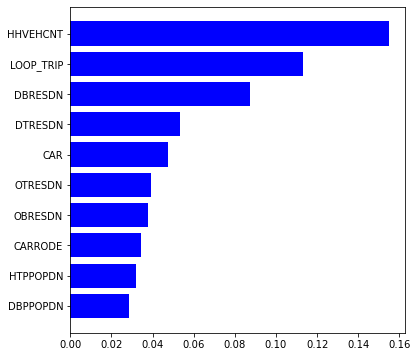

In [163]:
# feature importances top 10
features = X.columns
importances = rs.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(10), importances[indices][len(features)-10:len(features)], color='b', align='center')
plt.yticks(range(10), features[indices][len(features)-10:len(features)])
plt.show()

### 4-7. Down Sampling

In [187]:
df_rf_train, df_rf_test = train_test_split(df_rf, test_size=0.3)

In [188]:
df_rf_train['TARGET'].value_counts()

0    71362
1    12782
Name: TARGET, dtype: int64

In [189]:
sample_0 = df_rf_train[df_rf_train['TARGET'] == 0].sample(n=df_rf_train['TARGET'].value_counts()[1])

In [190]:
sample_1 = df_rf_train[df_rf_train['TARGET'] == 1]

In [191]:
trip_sample = pd.concat([sample_0, sample_1], axis=0)

In [192]:
y_ds_train = trip_sample['TARGET']
X_ds_train = trip_sample.drop('TARGET', axis=1)

In [193]:
y_ds_test = df_rf_test['TARGET']
X_ds_test = df_rf_test.drop('TARGET', axis=1)

In [194]:
# use the same parameters as the original model
rf_ds = RandomForestClassifier(n_estimators=26, n_jobs=-1, max_depth=15, max_leaf_nodes=50, min_samples_split=10)
rf_ds.fit(X_ds_train, y_ds_train)

RandomForestClassifier(max_depth=15, max_leaf_nodes=50, min_samples_split=10,
                       n_estimators=26, n_jobs=-1)

In [201]:
pred_rf_ds_train = rf_ds.predict(X_ds_train)

In [195]:
pred_rf_ds_test = rf_ds.predict(X_ds_test)

#### Performance on the training set

In [202]:
pd.DataFrame(confusion_matrix(y_ds_train, pred_rf_ds_train), index=['Actual 0', 'Actual 1'], columns=['Prediction 0', 'Prediction 1'])

Prediction 0  Prediction 1
Actual 0         11547          1235
Actual 1          2784          9998

In [203]:
accuracy_score(y_ds_train, pred_rf_ds_train)

0.8427867313409482

In [204]:
precision_score(y_ds_train, pred_rf_ds_train)

0.8900560847502893

In [205]:
recall_score(y_ds_train, pred_rf_ds_train)

0.7821937099045533

In [206]:
f1_score(y_ds_train, pred_rf_ds_train)

0.8326462627524464

#### Performance on the test set

In [207]:
pd.DataFrame(confusion_matrix(y_ds_test, pred_rf_ds_test), index=['Actual 0', 'Actual 1'], columns=['Prediction 0', 'Prediction 1'])

Prediction 0  Prediction 1
Actual 0         27721          3020
Actual 1          1217          4105

In [208]:
accuracy_score(y_ds_test, pred_rf_ds_test)

0.8825111610237639

In [209]:
precision_score(y_ds_test, pred_rf_ds_test)

0.576140350877193

In [210]:
recall_score(y_ds_test, pred_rf_ds_test)

0.771326568959038

In [211]:
f1_score(y_ds_test, pred_rf_ds_test)

0.6595966899654535

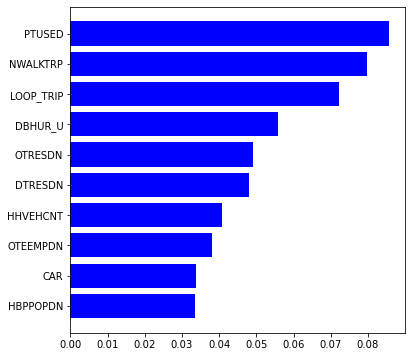

In [214]:
# feature importances top 10
features = X_ds_train.columns
importances = rf_ds.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(10), importances[indices][len(features)-10:len(features)], color='b', align='center')
plt.yticks(range(10), features[indices][len(features)-10:len(features)])
plt.show()

### 4-8. Over Sampling

In [217]:
oversample = SMOTE()

In [218]:
y_os = df_rf['TARGET']
X_os = df_rf.drop('TARGET', axis=1)

In [219]:
X_os, y_os = oversample.fit_resample(X_os, y_os)

In [227]:
counter = Counter(y_os)
print(counter)

Counter({0: 102103, 1: 102103})


In [224]:
X_os_train, X_os_test, y_os_train, y_os_test = train_test_split(X_os, y_os, test_size=0.3)

In [225]:
print(X_os_train.shape, X_os_test.shape, y_os_train.shape,  y_os_test.shape)

(142944, 163) (61262, 163) (142944,) (61262,)


In [229]:
# use the same parameters as the original model
rf_os = RandomForestClassifier(n_estimators=26, n_jobs=-1, max_depth=15, max_leaf_nodes=50, min_samples_split=10)
rf_os.fit(X_os_train, y_os_train)

RandomForestClassifier(max_depth=15, max_leaf_nodes=50, min_samples_split=10,
                       n_estimators=26, n_jobs=-1)

In [230]:
pred_rf_os_train = rf_os.predict(X_os_train)

In [231]:
pred_rf_os_test = rf_os.predict(X_os_test)

#### Performance on the training set

In [232]:
pd.DataFrame(confusion_matrix(y_os_train, pred_rf_os_train), index=['Actual 0', 'Actual 1'], columns=['Prediction 0', 'Prediction 1'])

Prediction 0  Prediction 1
Actual 0         66952          4529
Actual 1         10750         60713

In [233]:
accuracy_score(y_os_train, pred_rf_os_train)

0.8931119879113499

In [234]:
precision_score(y_os_train, pred_rf_os_train)

0.9305815272370559

In [235]:
recall_score(y_os_train, pred_rf_os_train)

0.8495725060520829

In [236]:
f1_score(y_os_train, pred_rf_os_train)

0.8882337880838301

#### Performance on the test set

Use the original test set rather than over-sampled test set.

In [244]:
pd.DataFrame(confusion_matrix(y_test, pred_rf_test), index=['Actual 0', 'Actual 1'], columns=['Prediction 0', 'Prediction 1'])

Prediction 0  Prediction 1
Actual 0         30159           394
Actual 1          2902          2608

In [245]:
accuracy_score(y_test, pred_rf_test)

0.9086043867676011

In [246]:
precision_score(y_test, pred_rf_test)

0.8687541638907396

In [247]:
recall_score(y_test, pred_rf_test)

0.4733212341197822

In [248]:
f1_score(y_test, pred_rf_test)

0.6127819548872181

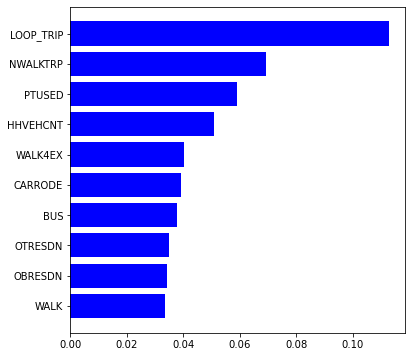

In [243]:
# feature importances top 10
features = X_os_train.columns
importances = rf_os.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(10), importances[indices][len(features)-10:len(features)], color='b', align='center')
plt.yticks(range(10), features[indices][len(features)-10:len(features)])
plt.show()